# Noise-Correlated SDEs for Asset Prices using Social Media Volume

## Introduction

I have recently developed an interest in Stochastic Differential Equations **(SDE)**'s, partly because of my recent training in stochastics, partly because a family member claims cryptocurrency is a future financial panacea and mostly due to a [2020 paper by Dipple et al.](https://doi.org/10.1007/s41109-020-00259-1) on using SDE knowledge to hack the crypto market with social media traffic.

The gist of *Dipple et al.* is rather straightforward: model the cryptocurrency price at a given point as the snapshot of Black-Scholes model which under a microscope is just a Geometric Brownian Motion **(GBM)** with certain parameters:

$$dX_t = \mu X_t dt + \sigma X_t dW_t$$

We then use an MLE to extract values of $\mu$ and $\sigma$ at a given time step. Simultaneously, we similarly estimate the parameters of a Geometric Ornstein-Uhlenbeck **(GOU)** process, first proposed by [Dixit and Pindyck in 1994](https://books.google.nl/books?id=8op0btN4mKEC) and modified by [Schwartz to its familiar form in 1997](https://doi.org/10.1111/j.1540-6261.1997.tb02721.x.) for modelling trading volumes, given by the SDE:

$$dX_t = \kappa X_t(\theta-\ln(X_t))dt+\sigma X_tdW_t$$

The underlying philosophy of applying the GOU is given in the paper's introduction as:

>Naturally, social media activity dynamics (referencing cryptocurrencies) and daily trading volumes exhibit significantly different features from those of the underlying cryptocurrencies. In particular, in these processes, after some possibly large spikes or drops (in response to some external “random" events) the corresponding stochastic variables have a tendency to return to some long-run mean.

Once these have been estimated, these models are then correlated and then used to generate a joint distribution for the next time step which can be used predictively - although not a higher degree of accuracy than "will it go up.

There is a lot of difficulty in acquiring either a [DARPA social media simulator](https://www.darpa.mil/program/computational-simulation-of-online-social-behavior) or enough money to leverage the [Historical Twitter APIs](https://developer.twitter.com/en/pricing/search-fullarchive), however. So some compromises have had to be made and the real test will come by leveraging the standard Twitter API.

To implement this model, however, I will need a lot of moving parts as SDEs and parameter estimation don't enjoy large/effective `sympy` derived modules. So this will read more like a journey of discovery, capped off with a limited test on the Twitter API.

### Our roadmap:

* The Underlying Math of SDEs and parameter estimation

    * Derive solutions and parameter estimates to the GOU process using Itô Calculus
    
    * Extract local parameters of the underlying GOU process from historical political twitter data
    
    * Derive solutions and parameter estimates to the GBM process using Itô Calculus
    
    * Extract local parameters of the underlying GBM process from historical BTC data
    
* Inference on Noise-Correlated SDEs and Computation

    * Derive process covariations and interpret them
    
    * Combine the covariations and parameter estimates to make predictions
    
* Combining our knowledge into two applications:

    * Test on a simulated GBM-GOU system of SDEs.

    * Test on live social media volume and Crypto/USD data
    
    * Draw conclusions
    
## SDEs and Their Estimation

We begin by analyzing the GOU with some data from a  useful historical source from [reddit](https://www.reddit.com/r/datasets/comments/6fniik/over_one_million_tweets_collected_from_us/), below this is parsed using `ijson` and `pandas`.

In [1]:
# Initialize modules

# ipython decoration
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# math/science
import numpy as np
import scipy as sp

# data wrangling
import ijson as ij
import pandas as pd
import matplotlib.pyplot as plt

# secret sauce
import pysde as sd

cp,ct = ("","")
out = []

for p,t,d in ij.parse(open("./data/tweets.json","r"),
                      multiple_values=True):
    
    # Loop to print one data entry
    
    if cp == p and ct == t:
        break
    if p != "" and cp == "":
        cp, ct = p, t
    
    # Print list of json keys
    
    if t != "map_key" and p != '':
        out.append(p)
        
print(out)

['contributors', 'coordinates', 'created_at', 'display_text_range', 'display_text_range.item', 'display_text_range.item', 'display_text_range', 'entities', 'entities.hashtags', 'entities.hashtags', 'entities.symbols', 'entities.symbols', 'entities.urls', 'entities.urls', 'entities.user_mentions', 'entities.user_mentions', 'entities', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place', 'retweet_count', 'retweeted', 'screen_name', 'source', 'text', 'truncated', 'user_id']


This data set is pretty rich, for our purposes though, we will only need the `created_at` and `user_id` keys.

In [2]:
new_a,new_b = (False,False)
df = []

for p,t,d in tqdm(ij.parse(open("./data/tweets.json","r"),
                      multiple_values=True)):
    
    # Loop to gather used_id and created_at only.
    
    if p == "user_id":
        a = d
        new_a = True
    if p == "created_at":
        b = d
        new_b = True
        
    if new_a == True and new_b == True:
        
        new_a,new_b = (False,False)
        df.append({"user_id":a,"created_at":b})
        
# Convert to pandas dataframe
        
df = pd.DataFrame(df)
df["created_at"] = pd.to_datetime(df["created_at"],unit="s")
df.head()

161311641it [02:43, 984906.14it/s] 


,user_id,created_at
0,5558312,2008-08-04 17:28:51
1,5558312,2008-08-06 19:04:45
2,5558312,2008-08-06 20:35:36
3,5558312,2008-08-07 13:52:52
4,5558312,2008-08-07 15:12:05


We now can bin this by hourly, daily and weekly counts to get a feeling for how this data looks.

Text(0.5, 1.0, 'Weekly')

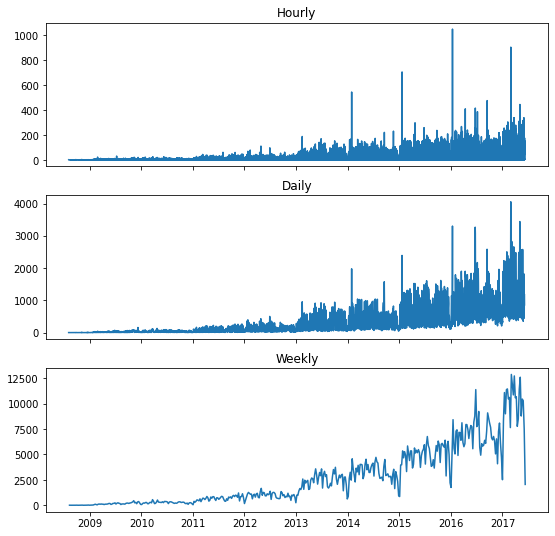

In [3]:
fig,axs = plt.subplots(3,sharex=True,figsize=(9,9))

axs[0].plot(df.resample('H', on='created_at').size())
axs[0].set_title("Hourly")
axs[1].plot(df.resample('D', on='created_at').size())
axs[1].set_title("Daily")
axs[2].plot(df.resample('W', on='created_at').size())
axs[2].set_title("Weekly")

The above graphs are precisely what we would expect: exponential growth in time with increasing variance (in fact, this growth curve is a great example of a sample of a GBM). This reflects the exponential adoption of Twitter by politicians, however, I do not believe this would vary significantly from the case with crypto social media volume: which must also have had historical exponential adoption - presumably the rate of adoption is so slow that the authors felt justified in using the rather flat GOU.

We'll now derive the MLEs used to determine the parameters of the underlying GOU. For computational purposes, the most advanced machinery that we will need is the Itô's integral, isometry and lemma: all of which can be found in any introductory book on Stochastic Calculus.

As a reminder, the GOU is defined by an SDE of the form:

$$dX_t = \kappa X_t(\theta-\ln(X_t))dt+\sigma X_tdW_t$$

By setting $U_t = \ln(X_t)$ and applying Itô's lemma, we get:

$$
\begin{align}
d\ln(X_t) = dU_t &= \left(\cancel{\dfrac{\partial U_t}{\partial t}}+\kappa \cancel{X_t}(\theta-\ln(X_t))\dfrac{1}{\cancel{X_t}}+\dfrac{\sigma^2 \cancel{X_t^2}}{2}\cdot\dfrac{-1}{\cancel{X_t^2}}\right)dt + \sigma \cancel{X_t}\dfrac{1}{\cancel{X_t}}dW_t\\
&= \left(\kappa(\theta-U_t)-\dfrac{\sigma^2}{2}\right)dt +\sigma dW_t\\
&= \kappa(\bar\theta-U_t)dt +\sigma dW_t
\end{align}
$$

Where $\bar\theta = \theta - \sigma^2/2\kappa$, we then solve by first considering the homogeneous case (in the typical PDE sense) which fortunately gives us an ODE with fundamental solution:

$$\dfrac{dU_t}{dt} = -\kappa U_t \implies \Phi_{t,0} = \exp \left(\int_{0}^t -\kappa ds\right) = \exp(-\kappa t)$$

By taking a second transformation $V_t=U_t/\Phi_{t,0}$ and substituting it into the SDE in $U_t$ with Itô's lemma again:

$$
\begin{align}
dV_t &= \left(\cancel{\kappa U_t e^{\kappa t}} + \kappa(\bar\theta-\cancel{U_t})e^{\kappa t}\right)dt + \sigma e^{\kappa t} dW_t\\
&= \kappa\bar\theta e^{\kappa t} dt + \sigma e^{\kappa t} dW_t
\end{align}
$$

Since there are no $V_t$'s in the right hand side, we can now directly compute the solution to our SDE:

$$
\begin{align}
V_t &= V_0+\int_0^t \kappa\bar\theta e^{\kappa s} ds + \int_0^t \sigma e^{\kappa s} dW_s\\
&= V_0+\bar\theta(e^{\kappa t}-1)+\sigma\psi(t)\sqrt{\dfrac{e^{2\kappa t}-1}{2\kappa}}\\
\implies U_t &= U_0+\bar\theta(1-e^{-\kappa t})+\sigma\psi(t)\sqrt{\dfrac{1-e^{-2\kappa t}}{2\kappa}}
\end{align}
$$

The resolution of the Itô integral is a consequence of the Itô isometry with a deterministic integrand.

With this computation in place, we are ready to continue to compute the MLE of this form. I have decided to omit it for this notebook, however, seeing as it is covered to what I consider sufficient depth in Appendix 1.2 of [Dipple et al. 2020](https://doi.org/10.1007/s41109-020-00259-1) and it is lengthy.

In summary, we have 3 MLEs that we must compute to get back an approximation of GOU parameters, the most important of these and the most fundamental is not actually explicitly stated as a model parameter.

$$
e^{-\hat\kappa\Delta t} = \dfrac{\sum_{i=1}^N\left(U_i-\frac{1}{N}\sum_{j=1}^N U_j\right)\left(U_{i-1}-\frac{1}{N}\sum_{j=1}^N U_{j-1}\right)}{\sum_{i=1}^N\left(U_{i-1}-\frac{1}{N}\sum_{j=1}^N U_{j-1}\right)^2}
$$

The reason why this is so important becomes immediately obvious with the two MLEs for the explicit model parameters,

$$
\hat{\bar\theta} = \dfrac{1}{N(1-e^{-\hat{\kappa}\Delta t})} \sum_{i=1}^N \left( U_{t_i}-U_{t_{i-1}}e^{-\hat{\kappa}\Delta t}\right)
$$

And,

$$
\hat\sigma^2 = \dfrac{2\hat\kappa}{N(1-e^{-2\hat\kappa\Delta t})}\sum_{i=1}^N\left(U_{t_i}-U_{t_{i-1}}e^{-\hat\kappa\Delta t} -\hat{\bar\theta}(1-e^{-\hat\kappa\Delta t})\right)^2
$$

With this mathematical aside over, it is worth mentioning how this will work in an implementation. What we have computed here is the expected parameters of a GOU between two points in time such that we have $N$ samples of the underlying data.

This gives us a "guess" for what comes next in a sequence of some data. So we can think of the predictive GOU that we use at any point a more complex moving average the mapped back to the solution of an SDE which gives us the "what happens next" aspect.

We now put these large expressions into python code that will let us compute these values on the above twitter data.

In [4]:
'''
Here we apply the formulas as we might expect:

An important step in using these functions is to ensure that
the data they are being fed is in a numpy array as pandas will
cause indexing problems.
'''


def ekappa_MLE(data):
    
    lag = np.log(data[:-1])
    tru = np.log(data[1:])
    
    lag = lag - np.mean(lag)
    tru = tru - np.mean(tru)
    
    nomin = np.mean(lag*tru)
    denom = np.mean(lag**2)
    
    return nomin/denom

def bartheta_MLE(data,ek):
    lag = np.log(data[:-1])
    tru = np.log(data[1:])
    
    mult = 1/(len(tru)*(1-ek))
    summ = np.sum(tru-lag*ek)
    
    return mult*summ
    
def sigma2_MLE(data,ek,b,dt):
    lag = np.log(data[:-1])
    tru = np.log(data[1:])

    k = -np.log(ek)*dt
    
    mult = (2*k)/(len(tru)*(1-ek**2))
    summ = sum((tru-(lag*ek)-(b*(1-ek)))**2)

    return (mult*summ)**0.5

# To handle the inherit bugginess of logging zeros

def fill_gaps(data):
    for idx in range(len(data)):
        i = idx
        try:
            while np.isnan(data[i]) or np.isinf(data[i]):
                i += 1
            data[idx] = data[i]
        except:
            i = idx
            while np.isnan(data[i]) or np.isinf(data[i]):
                i -= 1
            data[idx] = data[i]
    return data

We are now ready to write our first parameter estimators for the social media data using the above functions and a moving data aggregator. Let's start by estimating $e^{-\hat\kappa \Delta t}$ of hourly data over a day:

100%|██████████| 3229/3229 [00:00<00:00, 22080.93it/s]


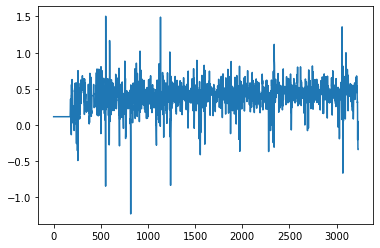

In [5]:
N = 7
daily = df.resample('d',on='created_at').size().to_numpy()
ekappa = []

for i in tqdm(range(len(daily))):
    ekappa.append(ekappa_MLE(daily[i:i+N+1]))

ekappa = fill_gaps(ekappa)    
    
plt.plot(ekappa)

And now we may repeat this process for $\hat\sigma$ and $\hat{\bar\theta}$ respectively:

100%|██████████| 3229/3229 [00:00<00:00, 55916.66it/s]


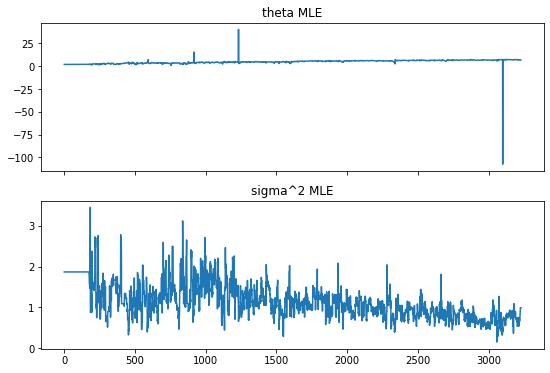

In [6]:
bart = []
sig2 = []

for i in tqdm(range(len(daily))):
    
    bart.append(bartheta_MLE(daily[i:i+N+1],ekappa[i]))
    
bar = fill_gaps(bart)

#filled_daily = fill_gaps(daily)
    
for i in tqdm(range(len(daily))):
    
    sig2.append(sigma2_MLE(daily[i:i+N+1],ekappa[i],bart[i],1))
    
sig2 = fill_gaps(sig2)
                
fig,axs = plt.subplots(2,sharex=True,figsize=(9,6))
axs[0].plot(bart)
axs[0].set_title("theta MLE")
axs[1].plot(sig2)
axs[1].set_title("sigma^2 MLE")

plt.show()

The average movements of these parameters can be better seen using a moving average to smooth out some of the noise.

Text(0.5, 1.0, 'sigma^2 MLE')

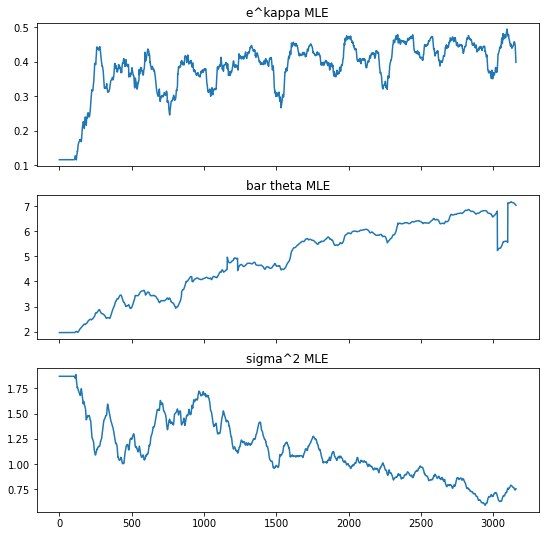

In [7]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

fig,axs = plt.subplots(3,sharex= True,figsize = (9,9))

axs[0].plot(moving_average(ekappa,72))
axs[0].set_title('e^kappa MLE')
axs[1].plot(moving_average(bart,72))
axs[1].set_title('bar theta MLE')
axs[2].plot(moving_average(sig2,72))
axs[2].set_title('sigma^2 MLE')

A similar process happens with the MLE's of the Geometric Brownian Motion, thankfully its form is far simpler and can be derived with a singular application of Itô's Lemma.

$$
dX_t = \mu X_t dt + \sigma X_t dW_t
$$

By setting $U_t=ln(X_t)$ and applying Itô's Lemma, we get:

$$
\begin{align}
dU_t &= \left(\mu \dfrac{\cancel{X_t}}{\cancel{X_t}} - \dfrac{\sigma^2}{2} \dfrac{\cancel{X_t^2}}{\cancel{X_t^2}}\right)dt + \dfrac{\sigma\cancel{X_t}}{\cancel{X_t}}dW_t\\
&= \left(\mu - \dfrac{\sigma^2}{2}\right)dt + \sigma dW_t
\end{align}
$$

Setting $\bar\mu = \mu - \sigma^2/2$, we can  then solve directly as these are just constants:

$$
\begin{align}
U_t &= U_0 + \int_0^t \bar\mu ds + \int_0^t \sigma dW_s\\
&= U_0 + \bar\mu t + \sigma W_t
\end{align}
$$

From this, it is now possible to derive the MLEs of the respective parameters with full derivation in Appendix 1.1 of *Dipple et al. 2020*:

$$\hat{\bar\mu} = \dfrac{1}{N}\sum_{i=1}^N (U_i - U_{i-1}) \qquad \hat\sigma^2 = \dfrac{1}{N\Delta t} \sum_{i=1}^N (U_i-U_{i-1}-\hat{\bar\mu}\Delta t)^2$$

We now repeat the above process using historical BTC/USD data to demonstrate the effect.

100%|██████████| 29709/29709 [00:00<00:00, 33453.96it/s]


Text(0.5, 1.0, '$\\hat\\sigma$')

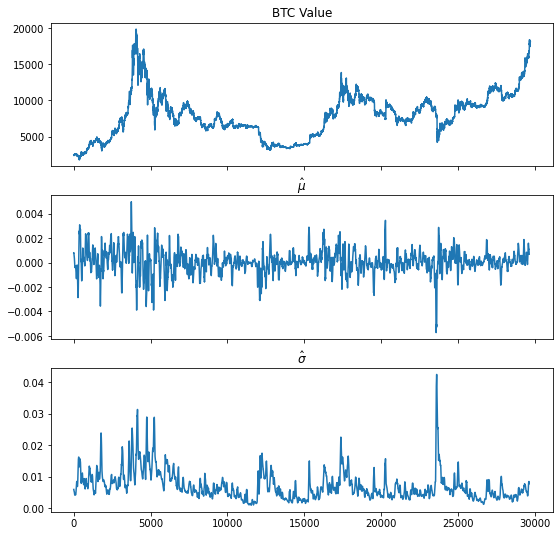

In [8]:
def barmu_MLE(data):
    return np.mean(np.log(data[1:])-np.log(data[:-1]))

def sigma_MLE(data,barmu,dt):
    return (np.mean((np.log(data[1:])-np.log(data[:-1])-barmu*dt)**2)/dt)**0.5

N = 24

btc = pd.read_csv("./data/Coinbase_BTCUSD_1h.csv",header=1)["Close"].iloc[::-1].to_numpy()

barmu = []
sigma = []

for i in tqdm(range(len(btc))):
    barmu.append(barmu_MLE(btc[i:i+N+1]))
    sigma.append(sigma_MLE(btc[i:i+N+1],barmu[-1],1))
    
mu = [m + (s/2) for m,s in list(zip(barmu,sigma))]

fig,axs = plt.subplots(3,sharex=True,figsize=(9,9))
axs[0].plot(btc)
axs[0].set_title("BTC Value")
axs[1].plot(moving_average(barmu,72))
axs[1].set_title("$\hat\mu$")
axs[2].plot(moving_average(sigma,72))
axs[2].set_title("$\hat\sigma$")

Now that we've introduced the basic methodology for empirically inferring the parameters of the presumed stochastic processes beneath our data, we can move onto the real trick of this paper: combining these data into a joint distribution of correlations  that we can then take marginals of to predict movements in a given direction.

In order to arrive at this joint model, we consider a system of SDEs neatly partitioned into GBMs and GOUs. We make only one assumption about that system, that there is possibly correlations between the underlying infinitesimal Wiener processes:

$$
\langle dW_jdW_k \rangle = \rho_{jk} dt
$$

Using the direct solutions we calculated above, we can find correlations in three scenarios: GBM-GBM, GOU-GOU and GBM-GOU. We recall that for a GBM we have:

$$
U_j(t) = U_j(0)+\bar\mu_j t + \int_0^t \sigma_j dW_j \implies U_j(t)-U_j(0)-\bar\mu_jt = \sigma_j \int_0^t dW_j
$$

Combining this with another GBM we then get the result:

$$
\sigma_j \sigma_k\int_0^t dW_j \int_0^t dW_k = (U_j(t)-U_j(0)-\bar\mu_jt)(U_k(t)-U_k(0)-\bar\mu_kt)
$$

Taking the expectation of both sides we then find:

$$
\sigma_j \sigma_k\mathbb{E}\left[\int_0^t dW_j \int_0^t dW_k\right] = \mathbb{E}[(U_j(t)-U_j(0)-\bar\mu_jt)(U_k(t)-U_k(0)-\bar\mu_kt)]
$$

Itô's isometry and the defining relation in our system of SDEs yields:

$$
\mathbb{E}\left[\int_0^t dW_j \int_0^t dW_k\right] = \mathbb{E}\left[\int_0^t \langle dW_j dW_k \rangle\right] = \mathbb{E}\left[\int_0^t \rho_{jk} ds\right] = \rho_{jk}t
$$

As the right hand side prior to the above equation is the expectation of a quadratic covariation, we can then write:

$$
\langle(U_j(t)-U_j(0)-\bar\mu_jt)(U_k(t)-U_k(0)-\bar\mu_kt)\rangle = \sigma_j\sigma_k\rho_{jk} t
$$

Repeating similar calculations for the GOU-GOU correlations, we find:

$$
U_j(t) = \bar\theta_j+(U_j(0)-\bar\theta_j)e^{-\kappa_j t}+\sigma e^{-\kappa_j t}\int_0^t e^{\kappa_j s} dW_j
$$

We perform a similar rearrangement, and instead we evaluate an expectation of a product of the above integral:

$$
\mathbb{E}\left[\int_0^t e^{\kappa_j s} dW_j \int_0^t e^{\kappa_k s} dW_k\right] = 
\mathbb{E}\left[\int_0^t e^{(\kappa_j + \kappa_k) s} \rho_{jk} ds\right] = \rho_{jk}\dfrac{e^{(\kappa_j+\kappa_k) t}-1}{\kappa_j+\kappa_k}
$$

And now we have:

$$
\langle (U_j(t) - \bar\theta_j -(U_j(0)-\bar\theta_j)e^{-\kappa_j t})(U_k(t) - \bar\theta_k -(U_k(0)-\bar\theta_k)e^{-\kappa_k t})\rangle = \sigma_j\sigma_k\rho_{jk}\dfrac{1-e^{-(\kappa_j+\kappa_k)t}}{\kappa_j+\kappa_k}
$$

Without further explanation, we can finally solve the GBM-GOU's "correlation integral":

$$
\mathbb{E}\left[\int_0^t dW_j \int_0^t e^{\kappa_k s} dW_k\right] = 
\mathbb{E}\left[\int_0^t e^{\kappa_k s} \rho_{jk} ds\right] = \rho_{jk}\dfrac{e^{\kappa_k t}-1}{\kappa_k}
$$

And so we now have the quadratic covariation:

$$
\left\langle (U_{j}(t)-U_{j}(0)-\bar{\mu}_{j} t) (U_{k}(t) - \bar{\theta}_{k} - (U_{k}(0)-\bar{\theta}_{k}) \mathrm{e}^{-\kappa_{k} t}) \right\rangle = \sigma_{j} \sigma_{k} \rho_{jk} \frac{1-e^{-\kappa_{k} t}}{\kappa_{k}} $$

These three results are then combined into MLEs for the multivariate GBM-GOU system. By simply taking the mean of the change in value provided in the above quantities we can derive the relevant joint MLEs. For instance if $j$ indexes a GBM and $k$ indexes a GOU - we have that:

$$
\Sigma_{jk}=\sigma_{j} \sigma_{k} \rho_{jk} \frac{1-e^{-\kappa_{k} \Delta t}}{\kappa_{k}}  \implies \hat\Sigma_{jk} = \hat\sigma_{j} \hat\sigma_{k} \hat\rho_{jk} \frac{1-e^{-\hat\kappa_{k} \Delta t}}{\hat\kappa_{k}}  = \dfrac{1}{N}\sum_{i=1}^N (U_{j}(t_i)-U_{j}(t_{i-1})-\hat{\bar{\mu}}_{j} \Delta t) (U_{k}(t_i) - \hat{\bar{\theta}}_{k} - (U_{k}(t_{i-1})-\hat{\bar{\theta}}_{k}) \mathrm{e}^{-\hat\kappa_{k} \Delta t})
$$

The design of the other MLEs follows a similar patterns and can be seen in full description in Appendix 3 of the paper.

Since, the correlation terms are for infinitesimal Weiner processes, the $\rho_{ij}$ that we derive describe covariances between normal distributions that are related to the transition probabilities of our SDEs via their solutions.

Explicitly for GBMs and GOUs respectively, these normal distributions are given by manipulating our solutions specifically noting that the transition distribution of a Weiner process is $\sqrt{t}N(0,1)$:

$$\psi_{GBM} (t)=\frac{1}{\sigma \sqrt{t}}\left(U(t)-U(0)-\bar{\mu}t \right) \qquad \psi_{GOU} (t) =\frac{U(t)-U(0)\mathrm{e}^{-\kappa t}-\bar{\theta}(1-\mathrm{e}^{-\kappa t})}{\sigma \sqrt{\frac{1-\mathrm{e}^{-2\kappa t}}{2\kappa}}}.$$

It follows that both $\psi$'s are distributed via $N(0,1)$ and by applying the appropriate rearrangement we see that $\rho_{ij}$'s correspond to the covariances of these standard normal distributions. However, these distributions are not independent, so we desire to arrive at a linear expression of our $\psi$'s using independent normal $\tilde\psi$'s (ie. $\langle\tilde\psi_i\tilde\psi_j\rangle = \delta_{ij}$).

This can be done using the Cholesky decomposition $\{\rho_{ij}\}=CC^{T}$ of the original covariance matrix, and then solving using substitution we find that:

$$\psi_i = \sum_{j} C_{ij}\tilde\psi_j$$

Using the derivation in the paper, it is then possible to see that:

$$\psi_n = \dfrac{\tilde\psi_n-\sum_{j=1}^{n-1}(C^{-1})_{nj}\psi_j}{(C^{-1})_{nn}}$$

Since the left-hand side is a standard normal distribution, $\tilde\psi_n$ can be generated using this information. By rearranging the order of our processes, we are left with an end-to-end scheme for generating samples that we can use to predict the transition distribution for the next time step of each SDE.

This provides us with the groundwork for our first attempt at an end-to-end implementation, which will work as follows:

- We estimate the parameters of our individual SDEs using all the MLEs we have computed
- We then convert our time series into a series of normal variables using our relation on $\psi$
- We use these normal distributions to estimate our underlying covariance matrix and its Cholesky decomp.
- We then work backwards using our linear relationship to estimate the next time step of our time series

In [9]:
class GBM_SDE():
    
    def __init__(self,dt):
        self.mu = []
        self.sigma = []
        self.dt = dt
        self.data = np.array([])
        
    def add_mu_MLE(self,data):
        global barmu_MLE
        self.mu.append(barmu_MLE(data))
        
    def add_sigma_MLE(self,data):
        global sigma_MLE
        self.sigma.append(sigma_MLE(data,self.mu[-1],self.dt))

class GOU_SDE():
    
    def __init__(self,dt):
        self.ekappa = []
        self.bartheta = []
        self.sigma = []
        self.dt = dt
        self.data = np.array([])
        
    def add_ekappa_MLE(self,data):
        global ekappa_MLE
        self.ekappa.append(ekappa_MLE(data))
        
    def add_bartheta_MLE(self,data):
        global bartheta_MLE
        self.bartheta.append(bartheta_MLE(data,self.ekappa[-1]))
        
    def add_sigma_MLE(self,data):
        global sigma2_MLE
        self.sigma.append(sigma2_MLE(data,
                          self.ekappa[-1],
                          self.bartheta[-1],
                          self.dt))

We can now combine these two classes into a single system class which we will use to compute and store all of our parameters and covariance matrices as necessary.

In [19]:
class GBM_GOU_System():
    
    def __init__(self,num_GBM,num_GOU,dt_list):
        
        self.sde_list = []
        
        for i in range(num_GBM):
            self.sde_list.append(GBM_SDE(dt_list[i]))
            
        for i in range(num_GBM,num_GBM+num_GOU):
            self.sde_list.append(GOU_SDE(dt_list[i]))
            
        self.corr_mat = []
        
# A quick method to determine what kind of SDE we are looking at
        
    def is_GBM(self,sde):
        sde = self.sde_list[sde]
        if sde.__class__.__name__ == "GBM_SDE":
            return True
        return False
    
    def update_system(self,indata):

# We compute new parameters using the MLE methods seen above

        corrmat = np.eye(len(self.sde_list))
        
        for idx,SDE in enumerate(self.sde_list):
            
            data = indata[idx]
            
            SDE.data = np.append(SDE.data,data[-1])
            
            if self.is_GBM(idx):
                SDE.add_mu_MLE(data)
                SDE.add_sigma_MLE(data)
            else:
                SDE.add_ekappa_MLE(data)
                SDE.add_bartheta_MLE(data)
                SDE.add_sigma_MLE(data)
                
# We now compute the underlying correlation matrix for the standard normals
# derived from the solutions to our SDEs
        
        for i in range(len(self.sde_list)):
                           
            for j in range(i+1,len(self.sde_list)):
                             
                if self.is_GBM(i) == True and self.is_GBM(j) == True:
                    
                    sde_i = self.sde_list[i]
                    sde_j = self.sde_list[j]
                    
                    par1 = np.log(indata[i][1:])-np.log(indata[i][:-1])-sde_i.mu[-1]*sde_i.dt
                    par2 = np.log(indata[j][1:])-np.log(indata[j][:-1])-sde_j.mu[-1]*sde_j.dt
                    
                    corrmat[i][j] = min(np.mean(par1*par2)/(sde_i.sigma[-1]*sde_j.sigma[-1]*self.sde_i.dt),1)
                    
                elif self.is_GBM(i) == False and self.is_GBM(j) == False:
                    
                    sde_i = self.sde_list[i]
                    sde_j = self.sde_list[j]
                    
                    par1 = np.log(indata[i][1:])-sde_i.bartheta[-1]-\
                    (np.log(indata[i])[:-1]-sde_i.bartheta[-1])*sde_i.ekappa[-1]*sde_i.dt
                    par2 = np.log(indata[j][1:])-sde_j.bartheta[-1]-\
                    (np.log(indata[j])[:-1]-sde_j.bartheta[-1])*sde_j.ekappa[-1]*sde_j.dt
                    
                    corrmat[i][j] = min((-np.log(sde_i.ekappa[-1]*sde_j.ekappa[-1]))*np.mean(par1*par2)/\
                    (sde_i.sigma[-1]*sde_j.sigma[-1]*(1-sde_i.ekappa[-1]*sde_j.ekappa[-1])),1)
                    
                elif self.is_GBM(i) == False and self.is_GBM(j) == True:
                    
                    sde_i = self.sde_list[i]
                    sde_j = self.sde_list[j]
                                        
                    par1 = np.log(indata[i][1:])-sde_i.bartheta[-1]-\
                    (np.log(indata[i])[:-1]-sde_i.bartheta[-1])*sde_i.ekappa[-1]*sde_i.dt
                    par2 = np.log(indata[j][1:])-np.log(indata[j][:-1])-sde_j.mu[-1]*sde_j.dt
                    
                    corrmat[i][j] = min(-np.log(sde_i.ekappa[-1])*np.mean(par1*par2)\
                    /(sde_i.sigma[-1]*sde_j.sigma[-1]*(1-sde_i.ekappa[-1])),1)
                    
                    
                else:
                    
                    sde_i = self.sde_list[i]
                    sde_j = self.sde_list[j]
                    
                    par1 = np.log(indata[j][1:])-sde_j.bartheta[-1]-\
                    (np.log(indata[j])[:-1]-sde_j.bartheta[-1])*sde_j.ekappa[-1]*sde_j.dt
                    par2 = np.log(indata[i][1:])-np.log(indata[i][:-1])-sde_i.mu[-1]*sde_i.dt
                                        
                    corrmat[i][j] = min(-np.log(sde_j.ekappa[-1])/(sde_j.sigma[-1]*sde_i.sigma[-1]*(1-sde_j.ekappa[-1]))*\
                    np.mean(par1*par2),1)
                    
        # Symmetrize to arrive at the final matrix                    
        corrmat =  np.maximum(corrmat,corrmat.transpose())    
        
        self.corr_mat.append(corrmat)
        
# We now compute the Cholesky decomposition of the correlation matrix
# and use it to impute transition probabilities and estimate the next time step

    def predict(self,idx,simulations):
                
        #Define row operations to match the above derived form
        row_ops = np.eye(len(self.sde_list))
        row_ops[[idx,len(self.sde_list)-1]] = row_ops[[len(self.sde_list)-1,idx]]
        
        #Take the cholesky decomposition and invert it
        invchole = np.linalg.cholesky(row_ops@self.corr_mat[-1]@row_ops)
        invchole = np.linalg.inv(invchole)
        
        #Extract relevant vector and use it to generate tilde psi n
        n = len(invchole[0])-1
        nchole = invchole[n,:]
        tildestd = (1-sum((nchole[:n]/nchole[n])**2))**0.5
        
        #Variance vector for simulation sample
        stdvec = nchole[:n]/nchole[n]
        
        #Simulate using underlying data
        simulated = np.random.normal(0,tildestd,simulations)-\
        np.sum(np.array([np.random.normal(0,abs(s),simulations) for s in stdvec]),axis=0)
        
        #Finally compute predicted values with confidence intervals of 1std        
        if self.is_GBM(idx):
            
            sde = self.sde_list[idx]
            mu = sde.mu[-1]
            dat = sde.data[-1]
            sig = sde.sigma[-1]
            dt = sde.dt
                        
            ut = dat * np.exp(mu + sig * simulated * dt**0.5)
            
            return np.mean(ut),np.std(ut)
            
        else:
            
            sde = self.sde_list[idx]
            ekap = sde.ekappa[-1]
            bart = sde.bartheta[-1]
            dat = sde.data[-1]
            sig = sde.sigma[-1]
            kap = np.log(ekap)
                        
            uwu = bart*(1-ekap)
            owo = sig*((ekap**2-1)/(2*kap))**0.5
            
            ut = np.exp(np.log(dat)*ekap+uwu+owo*simulated)
            
            return np.mean(ut),np.std(ut)

With this script now comprehended and written, we are now in a position to simulate some noise-correlated data and to see how well this method manages to predict coming trends using prior data. To do this, we will invert our lessons from the numerical scheme and take a sample from correlated parameters and then attempt to reverse engineer this using with the GBM-GOU model.

This is done most readily using solution, with a quick rearrangement we then have the iterative evolution of firsly the GBM:

$$
\begin{array}{*{20}l} &S(t_i) =S(t_{i-1})\text{exp}\left(\bar{\mu}\Delta t +\sigma \psi(t_i) \sqrt{\Delta t} \right),  \end{array}
$$

And secondly for the GOU:

$$
\begin{array}{*{20}l} &S(t_i) =\text{exp}\left (\ln \left(S(t_{i-1})\right)\mathrm{e}^{-\kappa \Delta t}+\bar{\theta}(1-\mathrm{e}^{-\kappa \Delta t})+\sigma \psi (t_i) \sqrt{\frac{1-\mathrm{e}^{-2\kappa \Delta t}}{2\kappa}} \right),  \end{array}
$$

These iterative steps rely on standard normal distribution, and this offers us the clue to make a simple correlated system of a GBM and GOU. Testing this naively with stationary parameters leads to numerical instability as the fairly constant GOU is forced to make predictions on an exponentially exploding GBM with scaled volatility.

To overcome this, a simulation is done using the found parameters of BTC and political twitter volume and then noise-correlated accordingly.

Text(0.5, 1.0, 'Simulated GOU process')

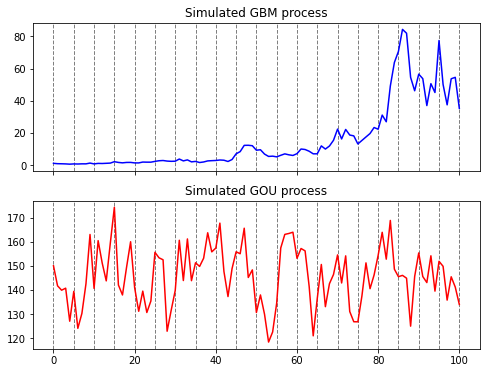

In [20]:
def GBM_trans(sns,s0,barmu,sig,noise):
    sns += np.random.normal(0,noise)
    return s0*np.exp(barmu+sig*sns)

def GOU_trans(sns,s0,ekap,sig,bart):
    return np.exp(np.log(s0)*ekap+bart*(1-ekap)+sig*sns*(((1-ekap**2)/(-2*np.log(ekap)))**0.5))

def quick_nc_data(length,noise):
    T = np.random.normal(0,1,length)
    GBM_out = [1]
    GOU_out = [150]

    for t in T:
        GBM_out.append(GBM_trans(t,GBM_out[-1],0.05,0.2,noise))
        GOU_out.append(GOU_trans(t,GOU_out[-1],0.5,0.1,5))
        
    return GBM_out, GOU_out

np.random.seed(1337)

X1,X2 = quick_nc_data(100,1)
    
fig,axs = plt.subplots(2,figsize=(8,6),sharex=True)

for i in range(0,101,5):
    axs[0].axvline(x=i,ls="--",lw=1,color="grey")
    axs[1].axvline(x=i,ls="--",lw=1,color="grey")
    
axs[0].plot(X1,color="blue",label="GBM")
axs[0].set_title('Simulated GBM process')
axs[1].plot(X2,color="red",label="GOU")
axs[1].set_title('Simulated GOU process')

Vertical lines have been added to the plot to make the effects of noise-correlation very clear. An upward trend in either process corresponds exactly with an upward trend in another. Although, since the expectation curve of the GBM is exponential, downward trends are not as dramatic on the GBM.

We will now try to use our `GBM_GOU_System` class to attempt to predict the next time step of the GBM using new data from the GOU (as we would under the assumptions made in the paper).

In [21]:
gbm_dat,gou_dat = quick_nc_data(1000,0.3)

gg = GBM_GOU_System(1,1,[1,1]) # 1 GBM, 1 GOU, dt = [1,1]
gg.update_system(np.array([gbm_dat[:100],gou_dat[:100]]))

Our system correctly works and now just as a quick sanity check, we ensure that the MLEs are estimating our input parameters effectively.

In [22]:
print('GBM MLEs:\n',gg.sde_list[0].mu,gg.sde_list[0].sigma)
print('GOU MLEs:\n',gg.sde_list[1].ekappa,gg.sde_list[1].sigma,gg.sde_list[1].bartheta)

GBM MLEs:
 [0.08292582409032145] [0.2093467861520741]
GOU MLEs:
 [0.6512940542611911] [0.08708526634691913] [5.018676046851507]


Checking above, we can see the MLEs are working correctly. We now see if the algorithm can now pick up the underlying noise-correlation:

In [23]:
gg.corr_mat

[array([[1.        , 0.94639079],
        [0.94639079, 1.        ]])]

With this computation now complete, we may finally attempt to use the code to predict the output of the GBM using synthesized data on the GOU.

In [24]:
gg.predict(0,10000000)

(4082.7508971536613, 864.3213160690404)

We can check the validity of our prediction by checking our final step in the data provided and the next value in the series.

In [25]:
print(gbm_dat[99:101])

[3676.27975963484, 4214.023183482464]


Not an incorrect prediction, although given that a downward turn is also within one standard deviation of the mean, this is not a confident prediction. We'll now examine using a sliding window on the data and predict as we go.

The logic that we use to evaluate this algorithm isn't a usual metric. We effectively wish to measure the number of correct "up or down" predictions that algorithm makes. We do this using a simple measure:

$$\text{UpDown Score} = \dfrac{1}{N}\sum_{i=1}^N\text{XNOR}(H(S(t_i)-S(t_{i-1})),H(Pr(t_i)-S(t_{i-1})))$$

Where $S$ corresponds to live data and $Pr$ is the predicted value and $H$ is the Heaviside step function centered at 0. The `XNOR` will use the standard defined truth table for the gate. We will then analyze how to improve this score using prediction uncertainty and other metrics we can derive from the predictions.

In [31]:
predictions = []
uncertainty = []

gg = GBM_GOU_System(1,1,[1,1])

for i in tqdm(range(300)):
    gg.update_system(np.array([gbm_dat[i:i+100],gou_dat[i:i+100]]))
    m,s = gg.predict(0,100000)
    predictions.append(m)
    uncertainty.append(s)
    
def updown(actual,predicted):
    a = np.array(actual)
    p = np.array(predicted)
    al = (a[1:]-a[:-1])#<0
    ap = (p[:-1]-a[:-1])#<0
    return np.logical_not(np.logical_xor(al<0,ap<0))

def mape(actual,predicted):
    a = np.array(actual)
    p = np.array(predicted)
    
    return np.mean(np.abs((p[:-1]-a[1:])/a[1:]))

print("The UpDown Score of our algorithm is:\t", np.mean(updown(gbm_dat[100:400],predictions)))
print("MAPE on Predictions:\t\t\t",mape(gbm_dat[100:400],predictions))

100%|██████████| 300/300 [00:02<00:00, 143.48it/s]

The UpDown Score of our algorithm is:	 0.568561872909699
MAPE on Predictions:			 0.21603726604385856


The MAPE presented here is significantly higher in the paper, due to an unrealistically high noise-correlation. However, the UpDown score which is a good metric of "if it goes up then it goes up" and vice versa seems to show that this algorithm can only produce marginally better results than outright guessing.

### Conclusion

Our naive implementation of the algorithm provides in the paper does not work as well as one might hope. There are several factors which contribute to this and inform the direction of future development:

#### Multivariate Correlation

In the paper it is mentioned that 5 cryptocurrency/USD prices and 4 social media volumes are correlated to make the final estimate on a single cryptocurrency, the larger number of predictors will presumably increase the UpDown score.

#### Look-ahead Calculations

In an actual use-case of this algorithm, it would make sense to contrast hourly social media volume against daily Crypto/USD prices. We would then estimate parameters (including correlation) from data that can certainly be correlated (as we have data) and then make predictions from new hourly data and take an increasingly precise estimate as the day draws to a close.

Using this method, our predictions would then become far more accurate and less sensitive to the jumps in value characteristic of a GOU process.

#### Final Remarks

The fact that this algorithm can perform as well as it can with so little data makes me optimistic about tackling the two problems outlined above. It is also worth noting that in experiments with this algorithm, as GBM takes its exponential course, the UpDown score begins to effectively random: this seems to be possible numerical instability in the algorithm: but should be of minimal concern for estimating actual daily price fluctations.